<a href="https://colab.research.google.com/github/kazuwjn/nerf-colab/blob/main/NeRF-Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NeRF (Neural Radiance Fields)

このノートブックでは、 NeRF (https://www.matthewtancik.com/nerf) を誰でも簡単に試せるように

* データセットの作成
* NeRFの学習
* 実験結果の可視化

ができるようになっています。

NeRFについて知りたい場合は以下のサイトなどを参考にしてください。

* https://ai-scholar.tech/articles/nerf/nerf
* https://www.slideshare.net/DeepLearningJP2016/dlnerf-representing-scenes-as-neural-radiance-fields-for-view-synthesis
* https://blog.albert2005.co.jp/2020/05/08/nerf/

応物ゼミ第2回のスライドです。簡単にNeRFとその前提知識についてまとめてあります。

https://drive.google.com/drive/folders/17vv_BQATx0_5nS9QuJ6XGWHPUJzTgng9?usp=sharing

<font color="FireBrick">注意: 学習時間の短縮のため、このノートブックでは torch-ngp (https://github.com/ashawkey/torch-ngp) を使用しています。</font> 

## データセット作成


動画または複数枚の画像からカメラの内部パラメータと外部パラメータを推定してデータセットを作成します。


すでにデータセットが作成できている場合は [NeRFの学習] に進んでください。

### 準備

1. Google アカウントをお持ちでない場合は Google アカウントを作成してください。
    
    https://accounts.google.com/signup

2. Google Drive をマウントし、必要なディレクトリを作成します。

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!mkdir -p "/content/drive/MyDrive/NeRF-Tutorial/datasets"

3. NeRFで復元したいオブジェクトを撮影してください。

    動画だとモーションブラーが発生しやすいので、画像をおすすめします。
    
    <details>
    <summary>注意: iPhoneで撮影する場合</summary>

    設定 > カメラ > フォーマット > カメラ撮影を「互換性優先」にしてください。
    <img src="http://drive.google.com/uc?export=view&id=1T_8VTS4REQyZ1gh4k7i91wtpwkXoPv5e" width="75%">
    </details>

4. 撮影した動画または複数枚の画像を Google Drive にアップロードしてください。
    
    スマートフォンで撮影した場合は Google Drive アプリ経由でアップロードすると良いです。
    
    <table style="border:none;">
    <tbody style="border:none;">
        <tr style="border:none;">
        <td style="border:none;" align="center">App Store</td>
        <td style="border:none;" align="center">Google Play Store</td>
        </tr>
        <tr style="border:none;">
        <td style="border:none;" align="center">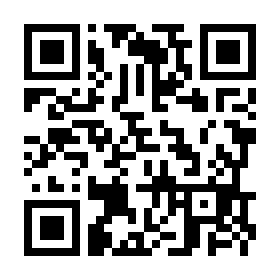</td>
        <td style="border:none;" align="center">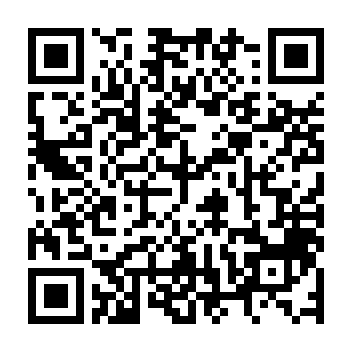</td>
        </tr>
    </tbody>
    </table>

    撮影した動画または画像は以下のフォルダに保存してください。

    ```
    MyDrive/NeRF-Tutorial/datasets/{適当なデータセットの名前}
    e.g. MyDrive/NeRF-Tutorial/datasets/miku
    ```

    <details>
    <summary>アップロードの仕方</summary>

    <img src="http://drive.google.com/uc?export=view&id=1U7td9vhnZAEjFCIyT9lHIY20HZLxOCnZ" width="30%">
    <img src="http://drive.google.com/uc?export=view&id=1dyOfhiiopBT7i7Reh8dnpfTv7OFiQGRU" width="30%">
    <img src="http://drive.google.com/uc?export=view&id=1lCivrC4ZoTLpMYOpSQOvjQAyWeXYW1Rw" width="30%">
    <img src="http://drive.google.com/uc?export=view&id=1HGZSWXaYRz8mQAmBC3Oq42BBMpC8ENXK" width="30%">
    <img src="http://drive.google.com/uc?export=view&id=1oUwX57tProLqSD4wWY2hEH5ZKzBpb6kd" width="30%">
    <img src="http://drive.google.com/uc?export=view&id=1oAdFXsTgvPS2thUn6dterSX_BoWYAjq-" width="30%">
    <img src="http://drive.google.com/uc?export=view&id=1NT7lmRw79QEI06D_3io1TtXrWJ4TR4al" width="30%">
    
    </details>

### 前処理

1. Google Drive をマウントします。

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

2. 撮影した動画または画像が保存されているフォルダパスを入力してください。

In [ ]:
#@title { display-mode: "form" }
#@markdown ←コード実行

from pathlib import Path

media_path = "/content/drive/MyDrive/NeRF-Tutorial/datasets/miku" # @param {type: 'string'}
media_path = Path(media_path)

images_dir = media_path / 'images'

3. 動画の場合は ffmpeg を使って連番画像に変換します。

    動画から切り出す画像の枚数を入力してください。

In [ ]:
#@title { display-mode: "form" }
#@markdown ←コード実行

import cv2

video_ext = ['*.mp4', '*.MP4', '*.mov', '*.MOV', '*.avi', '*.AVI']

video_paths = []
for ext in video_ext:
    video_paths.extend(media_path.glob(ext))

if len(video_paths) == 0:
    raise RuntimeError('動画ファイルが存在しません。（対応拡張子: mp4, mov, avi）')

video_path = video_paths[0]

target_num_frames = 100 # @param {type: 'number'}

cap = cv2.VideoCapture(str(video_path))
input_fps = cap.get(cv2.CAP_PROP_FPS)
num_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

if num_frames < target_num_frames:
  raise RuntimeError(f'動画のフレーム数がtarget_num_frames({target_num_frames})よりも少ない。')

fps = -(-target_num_frames * input_fps) // num_frames
print(f"FPS = {fps}")

tmp_images_dir = 'images/'
out_pattern = str('images/%04d.png')
!mkdir -p "$tmp_images_dir"
!ffmpeg -i "$video_path" -r $fps "$out_pattern"

images_dir = media_path
!mkdir -p "$images_dir"
!rsync -av "$tmp_images_dir/" "$images_dir/"

4. 画像の解像度を 600×600 以下になるように下げます。

    これは [COLMAPによるカメラパラメータ推定] の高速化のために行います。


In [ ]:
#@title { display-mode: "form" }
#@markdown ←コード実行

import imageio
import cv2

image_ext = ['*.png', '*.PNG', '*.jpg', '*.JPG', '*.jpeg', '*.JPEG']

image_paths = []
for ext in image_ext:
    image_paths.extend(media_path.glob(ext))

if len(image_paths) == 0:
    raise RuntimeError('画像ファイルが存在しません。（対応拡張子: png, jpg）')

image = imageio.imread(image_paths[0])
height, width = image.shape[:2]
resolution = height * width
scale = 1
while resolution > 600 * 600:
    scale <<= 1
    resolution >>= 2

images_dir = media_path / 'images'
images_dir.mkdir(exist_ok=True, parents=True)

for image_path in image_paths:
  print(f'Done: {image_path}')
  image = imageio.imread(image_path)
  height, width = image.shape[:2]
  out_height, out_width = height // scale, width // scale
  resized = cv2.resize(image, (out_width, out_height), cv2.INTER_AREA)
  resized_path = images_dir / f'{image_path.stem}.png'
  imageio.imwrite(resized_path, resized)

### COLMAPによるカメラパラメータ推定

COLMAPという SfM (Structure from Motion) のツールを使ってカメラの内部パラメータ及び外部パラメータを推定します。

In [ ]:
!apt install colmap

In [ ]:
#@title { display-mode: "form" }
#@markdown ←コード実行

#@markdown COLMAP でカメラパラメータを推定し、データセットを作成します。

#@markdown 画像解像度で処理時間が大きく変わりますが、だいたい30分ほどかかります。 

import os
from pathlib import Path

import numpy as np
import json
import sys
import math
import cv2
import os
import shutil

def run_colmap(args):
    db_path = args.colmap_db
    images_dir = args.images_dir
    text_dir = args.colmap_text
    flag_EAS = int(args.estimate_affine_shape) # 0 / 1

    sparse_dir = args.root_dir / "colmap_sparse"

    print(f"running colmap with:\n\tdb={db_path}\n\timages={images_dir}\n\tsparse={sparse_dir}\n\ttext={text_dir}")
    if os.path.exists(db_path):
        os.remove(db_path)
    
    !colmap feature_extractor --SiftExtraction.use_gpu 0  --ImageReader.camera_model OPENCV --ImageReader.single_camera 1 --database_path "{db_path}" --image_path "{images_dir}"
    !colmap {args.colmap_matcher}_matcher --SiftMatching.use_gpu 0 --database_path "{db_path}"
    # !wget https://demuc.de/colmap/vocab_tree_flickr100K_words32K.bin
    # !colmap vocab_tree_matcher --VocabTreeMatching.vocab_tree_path vocab_tree_flickr100K_words32K.bin --SiftMatching.use_gpu 0 --database_path "{db_path}"
    try:
        shutil.rmtree(sparse_dir)
    except:
        pass
    !mkdir "{sparse_dir}"
    !colmap mapper --database_path "{db_path}" --image_path "{images_dir}" --export_path "{sparse_dir}"
    !colmap bundle_adjuster --input_path "{sparse_dir}/0" --output_path "{sparse_dir}/0" --BundleAdjustment.refine_principal_point 1
    try:
        shutil.rmtree(text_dir)
    except:
        pass
    !mkdir "{text_dir}"
    !colmap model_converter --input_path "{sparse_dir}/0" --output_path "{text_dir}" --output_type TXT

def variance_of_laplacian(image):
    return cv2.Laplacian(image, cv2.CV_64F).var()

def sharpness(imagePath):
    image = cv2.imread(imagePath)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    fm = variance_of_laplacian(gray)
    return fm

def qvec2rotmat(qvec):
    return np.array([
        [
            1 - 2 * qvec[2]**2 - 2 * qvec[3]**2,
            2 * qvec[1] * qvec[2] - 2 * qvec[0] * qvec[3],
            2 * qvec[3] * qvec[1] + 2 * qvec[0] * qvec[2]
        ], [
            2 * qvec[1] * qvec[2] + 2 * qvec[0] * qvec[3],
            1 - 2 * qvec[1]**2 - 2 * qvec[3]**2,
            2 * qvec[2] * qvec[3] - 2 * qvec[0] * qvec[1]
        ], [
            2 * qvec[3] * qvec[1] - 2 * qvec[0] * qvec[2],
            2 * qvec[2] * qvec[3] + 2 * qvec[0] * qvec[1],
            1 - 2 * qvec[1]**2 - 2 * qvec[2]**2
        ]
    ])

def rotmat(a, b):
	a, b = a / np.linalg.norm(a), b / np.linalg.norm(b)
	v = np.cross(a, b)
	c = np.dot(a, b)
	# handle exception for the opposite direction input
	if c < -1 + 1e-10:
		return rotmat(a + np.random.uniform(-1e-2, 1e-2, 3), b)
	s = np.linalg.norm(v)
	kmat = np.array([[0, -v[2], v[1]], [v[2], 0, -v[0]], [-v[1], v[0], 0]])
	return np.eye(3) + kmat + kmat.dot(kmat) * ((1 - c) / (s ** 2 + 1e-10))

def closest_point_2_lines(oa, da, ob, db): # returns point closest to both rays of form o+t*d, and a weight factor that goes to 0 if the lines are parallel
    da = da / np.linalg.norm(da)
    db = db / np.linalg.norm(db)
    c = np.cross(da, db)
    denom = np.linalg.norm(c)**2
    t = ob - oa
    ta = np.linalg.det([t, db, c]) / (denom + 1e-10)
    tb = np.linalg.det([t, da, c]) / (denom + 1e-10)
    if ta > 0:
        ta = 0
    if tb > 0:
        tb = 0
    return (oa+ta*da+ob+tb*db) * 0.5, denom

class Arg():
    def __init__(self):
        self.root_dir = images_dir.parent
        self.images_dir = images_dir
        self.run_colmap = True
        self.dynamic = False
        self.estimate_affine_shape = False
        self.hold = 8
        self.video_fps = 3
        self.time_slice = ""
        self.colmap_matcher = "exhaustive"
        self.skip_early = 0
        self.colmap_db = "colmap.db"
        self.colmap_text = "colmap_text"

args = Arg()

args.colmap_db = args.root_dir / args.colmap_db
args.colmap_text = args.root_dir / args.colmap_text

if args.run_colmap:
    run_colmap(args)

SKIP_EARLY = int(args.skip_early)
TEXT_FOLDER = args.colmap_text

with open(os.path.join(TEXT_FOLDER, "cameras.txt"), "r") as f:
    angle_x = math.pi / 2
    for line in f:
        # 1 SIMPLE_RADIAL 2048 1536 1580.46 1024 768 0.0045691
        # 1 OPENCV 3840 2160 3178.27 3182.09 1920 1080 0.159668 -0.231286 -0.00123982 0.00272224
        # 1 RADIAL 1920 1080 1665.1 960 540 0.0672856 -0.0761443
        if line[0] == "#":
            continue
        els = line.split(" ")
        w = float(els[2])
        h = float(els[3])
        fl_x = float(els[4])
        fl_y = float(els[4])
        k1 = 0
        k2 = 0
        p1 = 0
        p2 = 0
        cx = w / 2
        cy = h / 2
        if els[1] == "SIMPLE_PINHOLE":
            cx = float(els[5])
            cy = float(els[6])
        elif els[1] == "PINHOLE":
            fl_y = float(els[5])
            cx = float(els[6])
            cy = float(els[7])
        elif els[1] == "SIMPLE_RADIAL":
            cx = float(els[5])
            cy = float(els[6])
            k1 = float(els[7])
        elif els[1] == "RADIAL":
            cx = float(els[5])
            cy = float(els[6])
            k1 = float(els[7])
            k2 = float(els[8])
        elif els[1] == "OPENCV":
            fl_y = float(els[5])
            cx = float(els[6])
            cy = float(els[7])
            k1 = float(els[8])
            k2 = float(els[9])
            p1 = float(els[10])
            p2 = float(els[11])
        else:
            print("unknown camera model ", els[1])
        # fl = 0.5 * w / tan(0.5 * angle_x);
        angle_x = math.atan(w / (fl_x * 2)) * 2
        angle_y = math.atan(h / (fl_y * 2)) * 2
        fovx = angle_x * 180 / math.pi
        fovy = angle_y * 180 / math.pi

print(f"camera:\n\tres={w,h}\n\tcenter={cx,cy}\n\tfocal={fl_x,fl_y}\n\tfov={fovx,fovy}\n\tk={k1,k2} p={p1,p2} ")

with open(os.path.join(TEXT_FOLDER, "images.txt"), "r") as f:
    i = 0

    bottom = np.array([0.0, 0.0, 0.0, 1.0]).reshape([1, 4])

    frames = []

    up = np.zeros(3)
    for line in f:
        line = line.strip()

        if line[0] == "#":
            continue

        i = i + 1
        if i < SKIP_EARLY*2:
            continue

        if i % 2 == 1:
            elems = line.split(" ") # 1-4 is quat, 5-7 is trans, 9ff is filename (9, if filename contains no spaces)

            name = '_'.join(elems[9:])
            full_name = str(args.images_dir / name)
            rel_name = f'images/{name}'

            b = sharpness(full_name)
            # print(name, "sharpness =",b)

            image_id = int(elems[0])
            qvec = np.array(tuple(map(float, elems[1:5])))
            tvec = np.array(tuple(map(float, elems[5:8])))
            R = qvec2rotmat(-qvec)
            t = tvec.reshape([3, 1])
            m = np.concatenate([np.concatenate([R, t], 1), bottom], 0)
            c2w = np.linalg.inv(m)
            
            c2w[0:3, 2] *= -1 # flip the y and z axis
            c2w[0:3, 1] *= -1
            c2w = c2w[[1, 0, 2, 3],:] # swap y and z
            c2w[2, :] *= -1 # flip whole world upside down

            up += c2w[0:3, 1]

            frame = {
                "file_path": rel_name, 
                "sharpness": b, 
                "transform_matrix": c2w
            }

            frames.append(frame)

N = len(frames)
up = up / np.linalg.norm(up)

print("[INFO] up vector was", up)

R = rotmat(up, [0, 0, 1]) # rotate up vector to [0,0,1]
R = np.pad(R, [0, 1])
R[-1, -1] = 1

for f in frames:
    f["transform_matrix"] = np.matmul(R, f["transform_matrix"]) # rotate up to be the z axis

# find a central point they are all looking at
print("[INFO] computing center of attention...")
totw = 0.0
totp = np.array([0.0, 0.0, 0.0])
for f in frames:
    mf = f["transform_matrix"][0:3,:]
    for g in frames:
        mg = g["transform_matrix"][0:3,:]
        p, weight = closest_point_2_lines(mf[:,3], mf[:,2], mg[:,3], mg[:,2])
        if weight > 0.01:
            totp += p * weight
            totw += weight
totp /= totw
for f in frames:
    f["transform_matrix"][0:3,3] -= totp
avglen = 0.
for f in frames:
    avglen += np.linalg.norm(f["transform_matrix"][0:3,3])
avglen /= N
print("[INFO] avg camera distance from origin", avglen)
for f in frames:
    f["transform_matrix"][0:3,3] *= 4.0 / avglen # scale to "nerf sized"

# sort frames by id
frames.sort(key=lambda d: d['file_path'])

# add time if scene is dynamic
if args.dynamic:
    for i, f in enumerate(frames):
        f['time'] = i / N

for f in frames:
    f["transform_matrix"] = f["transform_matrix"].tolist()

# construct frames

def write_json(filename, frames):

    out = {
        "camera_angle_x": angle_x,
        "camera_angle_y": angle_y,
        "fl_x": fl_x,
        "fl_y": fl_y,
        "k1": k1,
        "k2": k2,
        "p1": p1,
        "p2": p2,
        "cx": cx,
        "cy": cy,
        "w": w,
        "h": h,
        "frames": frames,
    }

    output_path = args.root_dir / filename
    print(f"[INFO] writing {len(frames)} frames to {output_path}")
    with open(output_path, "w") as outfile:
        json.dump(out, outfile, indent=2)

# just one transforms.json, don't do data split
if args.hold <= 0:

    write_json('transforms.json', frames)
    
else:
    all_ids = np.arange(N)
    test_ids = all_ids[::args.hold]
    train_ids = np.array([i for i in all_ids if i not in test_ids])

    frames_train = [f for i, f in enumerate(frames) if i in train_ids]
    frames_test = [f for i, f in enumerate(frames) if i in test_ids]

    write_json('transforms_train.json', frames_train)
    write_json('transforms_val.json', frames_test[::10])
    write_json('transforms_test.json', frames_test)

## NeRFの学習

このノートブックでは、NeRFの学習時間の短縮のために [torch-ngp](https://github.com/ashawkey/torch-ngp) を使います。

通常のNeRFでは学習時間が10時間以上かかりますが、 torch-ngp では1時間以内に学習が終わります。

1. Google Drive をマウントします。

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

2. 必要なコードとモジュールをインストールします。

In [ ]:
!git clone --recursive https://github.com/ashawkey/torch-ngp.git
%cd /content/torch-ngp/
!pip install -r requirements.txt
!pip install imageio-ffmpeg

3. データセットが保存されているフォルダパスを入力してください。

In [ ]:
#@title { display-mode: "form" }
#@markdown ←コード実行

from pathlib import Path

dataset_path = "/content/drive/MyDrive/NeRF-Tutorial/datasets/miku" # @param {type: 'string'}
dataset_path = Path(dataset_path)

4. NeRF (torch-ngp) を学習します。

    学習結果は `MyDrive/NeRF-Tutorial/experiments/exp_{日付}` に保存されます。

In [ ]:
#@title { display-mode: "form" }
#@markdown ←コード実行

import datetime
now_jst = datetime.datetime.now(datetime.timezone(datetime.timedelta(hours=9))).strftime('%m%d%H%M')

scale = 1 #@param {type:"slider", min:0.1, max:2, step:0.1}
bound = 8 #@param {type:"slider", min:1, max:16, step:1}
bg_radius = 32 #@param {type:"slider", min:16, max:64, step:16}
iters = 25000 #@param {type:"slider", min:20000, max:30000, step:1000}

!python main_nerf.py "{dataset_path}" --workspace "exp_{now_jst}" --fp16 --cuda_ray --scale {scale} --bound {bound} --dt_gamma 0.00 --bg_radius {bg_radius} --iters {iters}
!mkdir -p "/content/drive/MyDrive/NeRF-Tutorial/experiments/exp_{now_jst}"
!rsync -av "/content/torch-ngp/exp_{now_jst}/" "/content/drive/MyDrive/NeRF-Tutorial/experiments/exp_{now_jst}"

## 実験結果の可視化

1. Google Drive をマウントします。

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

2. 必要なコードとモジュールをインストールします。

In [ ]:
!git clone --recursive https://github.com/ashawkey/torch-ngp.git
%cd /content/torch-ngp/
!pip install -r requirements.txt
!pip install imageio-ffmpeg

3. データセットが保存されているフォルダパスと学習結果が保存されているフォルダパスを入力してください。

In [ ]:
#@title { display-mode: "form" }
#@markdown ←コード実行

from pathlib import Path

dataset_path = "/content/drive/MyDrive/NeRF-Tutorial/datasets/miku" # @param {type: 'string'}
dataset_path = Path(dataset_path)
exp_path = "/content/drive/MyDrive/NeRF-Tutorial/experiments/exp_08302153" # @param {type: 'string'}
exp_path = Path(exp_path)
mesh_path = exp_path / "meshes"
mesh_path = next(mesh_path.glob("*.ply"))

3. レンダリングするフレーム数と視点の角度と距離を入力してください。

In [ ]:
#@title { display-mode: "form" }
#@markdown ←コード実行

import numpy as np
import json

test_path = dataset_path / "transforms_test.json.bak"
if not test_path.exists():
    test_path = dataset_path / "transforms_test.json"
    !cp "{dataset_path}/transforms_test.json" "{dataset_path}/transforms_test.json.bak"

with open(test_path, "r") as f:
    transform = json.load(f)

num_frames = 40 #@param {type:"slider", min:1, max:100, step:1}
elev = 30 #@param {type:"slider", min:0.0, max:90.0, step:1.0}
dist = 4.0 #@param {type:"slider", min:1, max:10, step:1}

trans_t = lambda t : np.array([
    [1,0,0,0],
    [0,1,0,0],
    [0,0,1,t],
    [0,0,0,1]])

rot_phi = lambda phi : np.array([
    [1,0,0,0],
    [0,np.cos(phi),-np.sin(phi),0],
    [0,np.sin(phi), np.cos(phi),0],
    [0,0,0,1]])

rot_theta = lambda th : np.array([
    [np.cos(th),0,-np.sin(th),0],
    [0,1,0,0],
    [np.sin(th),0, np.cos(th),0],
    [0,0,0,1]])

def pose_spherical(theta, phi, radius):
    c2w = trans_t(radius)
    c2w = rot_phi(phi/180.*np.pi) @ c2w
    c2w = rot_theta(theta/180.*np.pi) @ c2w
    c2w = np.array([[-1,0,0,0],[0,0,1,0],[0,1,0,0],[0,0,0,1]]) @ c2w
    return c2w

c2w = np.stack([pose_spherical(angle, -elev, dist) for angle in np.linspace(-180,180,num_frames+1)[:-1]], 0)
c2w = c2w.tolist()

frames = []
rel_name = transform["frames"][0]["file_path"]
for i in range(num_frames):
    frame = {
        "file_path": rel_name, 
        "transform_matrix": c2w[i]
    }
    frames.append(frame)

transform["frames"] = frames
output_path = dataset_path / "transforms_test.json"
with open(output_path, "w") as outfile:
    json.dump(transform, outfile, indent=2)

4. NeRF (torch-ngp) の学習結果をレンダリングします。

In [ ]:
#@title { display-mode: "form" }
#@markdown ←コード実行

scale = 1 #@param {type:"slider", min:0.1, max:2, step:0.1}
bound = 8 #@param {type:"slider", min:1, max:16, step:1}
bg_radius = 32 #@param {type:"slider", min:16, max:64, step:16}

!python main_nerf.py "{dataset_path}" --workspace "{exp_path}" --fp16 --cuda_ray --scale {scale} --bound {bound} --dt_gamma 0.00 --bg_radius {bg_radius} --test

In [ ]:
from IPython.display import HTML

def display_mp4(path):
    print(f'Read from {path}')
    from base64 import b64encode
    mp4 = open(path,'rb').read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
    display(HTML("""
    <video controls loop autoplay>
        <source src="%s" type="video/mp4">
    </video>
    """ % data_url))
    print('Display finished.')

display_mp4("/content/drive/MyDrive/NeRF-Tutorial/experiments/exp_08302153/results/ngp_ep0338_rgb.mp4")